# DQN Training
Training a DQN agent using custom gym environment and keras-rl2.

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

from gym import Env
from gym.spaces import Discrete, Box

from rl.agents import DQNAgent
from rl.policy import MaxBoltzmannQPolicy, BoltzmannQPolicy, LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory

## Functions

In [2]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), "valid") / w

# Environment

## Loading Shape Class

In [3]:
import sys  
sys.path.insert(0, "E:\Projects\Python\TetrisRoyaleRL")

from settings import *
from game_env.shapes import Shape
from game_env.game_env import GameEnv

## Reworking the Environment

## Define new functions

In [4]:
def heuristic(self):
        temp_map = self.map
        # sum of heights
        heights = 24 - np.argmax(temp_map[:, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS] == 1, axis=0)
        sum_hights = heights.sum()

        # bumpiness
        bumpiness = 0
        for i in range(heights.shape[0] - 1):
            bumpiness += (heights[i] - heights[i + 1]) ** 2

        # complete rows
        temp_map = temp_map[GAME_SHAPE_TOP_HIDDEN: -GAME_SHAPE_BORDERS, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS]
        complete_rows = (np.where(temp_map.sum(axis=1) == 10)[0]).size

        # count of holes
        holes = 0
        for i in range(1, temp_map.shape[0]):
            for j in range(temp_map.shape[1]):
                if temp_map[i, j] == 0 and temp_map[i-1, j] == 1:
                    holes += 1

        total = -0.6 * sum_hights \
                + 0.75 * complete_rows \
                - 0.35 * holes \
                - 0.1 * bumpiness
        return total / 10

In [5]:
def new_state_observe(self):
        # observable map
        temp_map = self.map[GAME_SHAPE_TOP_HIDDEN:-GAME_SHAPE_BORDERS, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS].copy()
        
        # observation of cur shape on map
        temp_shape = np.zeros(self.map.shape)
        x0 = self.shape.x
        y0 = int(self.shape.y)
        this_shape = self.shape.get_shape()
        temp_shape[y0: y0 + this_shape.shape[0], x0: x0 + this_shape.shape[1]] += this_shape
        temp_shape = temp_shape[GAME_SHAPE_TOP_HIDDEN:-GAME_SHAPE_BORDERS, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS]
        
        # next shape on map, assuming y0 = 0
        temp_next_shape = np.zeros((20, 10))
        x0 = self.next_shape.x - GAME_SHAPE_BORDERS
        next_shape = self.next_shape.get_shape()
        temp_next_shape[0: next_shape.shape[0], x0: x0 + next_shape.shape[1]] += next_shape

        return np.stack([temp_map, temp_shape, temp_next_shape], axis=-1).astype(np.float32)

In [6]:
def reward_alive(self):
    return 1

## Assign new functions

In [7]:
GameEnv._state_observe = new_state_observe
GameEnv._reward_after_lock_figure = heuristic
GameEnv._reward_for_alive = reward_alive

## Create env

In [8]:
env = GameEnv()
env.observation_space = Box(low=0.0, high=1.0, shape=(20, 10, 3))
env.gravity = 1

## Test Random

In [9]:
episodes = 25
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0
    steps = 0
    while not done:
        action = np.random.randint(0, 5)
        n_state, reward, done, info = env.step(action)
        score+=reward
        steps +=1
    print("Episode: {}, Score: {}, Steps: {}".format(episode, score, steps))

Episode: 1, Score: 120.95500000000003, Steps: 223
Episode: 2, Score: 161.51999999999998, Steps: 273
Episode: 3, Score: 56.43000000000003, Steps: 180
Episode: 4, Score: 102.90500000000002, Steps: 166
Episode: 5, Score: 120.52, Steps: 238
Episode: 6, Score: 101.15499999999997, Steps: 200
Episode: 7, Score: 117.60000000000001, Steps: 242
Episode: 8, Score: 79.44, Steps: 135
Episode: 9, Score: 102.845, Steps: 196
Episode: 10, Score: 129.73, Steps: 212
Episode: 11, Score: 66.365, Steps: 219
Episode: 12, Score: 72.4, Steps: 169
Episode: 13, Score: 131.24000000000004, Steps: 269
Episode: 14, Score: 146.41500000000002, Steps: 270
Episode: 15, Score: 132.755, Steps: 226
Episode: 16, Score: 100.38000000000001, Steps: 180
Episode: 17, Score: 19.22499999999997, Steps: 170
Episode: 18, Score: 117.49500000000002, Steps: 247
Episode: 19, Score: 82.85499999999999, Steps: 228
Episode: 20, Score: 119.14000000000001, Steps: 232
Episode: 21, Score: 137.47499999999997, Steps: 242
Episode: 22, Score: 123.00

## Test do-nothing

In [10]:
episodes = 25
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0
    steps = 0
    while not done:
        action = -1
        n_state, reward, done, info = env.step(action)
        score+=reward
        steps +=1
    print("Episode: {}, Score: {}, Steps: {}".format(episode, score, steps))

Episode: 1, Score: 127.53500000000001, Steps: 266
Episode: 2, Score: 129.8, Steps: 241
Episode: 3, Score: 139.84499999999997, Steps: 230
Episode: 4, Score: 98.83000000000003, Steps: 218
Episode: 5, Score: 101.93500000000003, Steps: 229
Episode: 6, Score: 183.32999999999996, Steps: 274
Episode: 7, Score: 125.43999999999996, Steps: 230
Episode: 8, Score: 170.50000000000003, Steps: 254
Episode: 9, Score: 164.10499999999996, Steps: 265
Episode: 10, Score: 88.83500000000001, Steps: 198
Episode: 11, Score: 115.98999999999998, Steps: 218
Episode: 12, Score: 151.11499999999998, Steps: 258
Episode: 13, Score: 48.364999999999995, Steps: 172
Episode: 14, Score: 134.08500000000004, Steps: 228
Episode: 15, Score: 127.12999999999998, Steps: 250
Episode: 16, Score: 141.76, Steps: 213
Episode: 17, Score: 128.86, Steps: 265
Episode: 18, Score: 138.27499999999998, Steps: 244
Episode: 19, Score: 93.35000000000002, Steps: 170
Episode: 20, Score: 122.22499999999997, Steps: 209
Episode: 21, Score: 73.820000

## Test to-side

In [11]:
episodes = 25
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0
    steps = 0
    while not done:
        action = 1
        n_state, reward, done, info = env.step(action)
        score+=reward
        steps +=1
    print("Episode: {}, Score: {}, Steps: {}".format(episode, score, steps))

Episode: 1, Score: 113.185, Steps: 159
Episode: 2, Score: 100.445, Steps: 142
Episode: 3, Score: 90.685, Steps: 130
Episode: 4, Score: 93.41000000000001, Steps: 130
Episode: 5, Score: 97.59499999999997, Steps: 148
Episode: 6, Score: 106.46499999999997, Steps: 145
Episode: 7, Score: 103.82499999999999, Steps: 141
Episode: 8, Score: 96.30499999999999, Steps: 139
Episode: 9, Score: 88.63000000000001, Steps: 136
Episode: 10, Score: 103.93499999999997, Steps: 151
Episode: 11, Score: 101.80499999999998, Steps: 143
Episode: 12, Score: 111.08500000000001, Steps: 155
Episode: 13, Score: 132.64000000000001, Steps: 180
Episode: 14, Score: 94.57499999999999, Steps: 130
Episode: 15, Score: 120.89999999999999, Steps: 163
Episode: 16, Score: 90.55000000000001, Steps: 138
Episode: 17, Score: 90.22000000000001, Steps: 130
Episode: 18, Score: 111.195, Steps: 157
Episode: 19, Score: 92.775, Steps: 130
Episode: 20, Score: 96.71000000000001, Steps: 140
Episode: 21, Score: 119.72, Steps: 159
Episode: 22, Sc

# Nural Network and Agent

## Build model

In [12]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [13]:
def build_model():
    return tf.keras.Sequential([
    # 1 state, 20 rows, 10 cols, 3 matricies: locked, falling and next figures
    layers.Input(shape=(1, 20, 10, 3)),
    layers.Reshape(target_shape=(20, 10, 3)),
    
    layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same"),
    layers.Activation("relu"),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same"),
    layers.Activation("relu"),
    layers.MaxPool2D(),
    
    layers.Flatten(),
    
    layers.Dense(32),
    layers.Activation("relu"),
    
    layers.Dense(16),
    layers.Activation("relu"),
    
    layers.Dense(5)])

In [14]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 20, 10, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 20, 10, 32)        896       
                                                                 
 activation (Activation)     (None, 20, 10, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 5, 32)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 5, 64)         18496     
                                                                 
 activation_1 (Activation)   (None, 10, 5, 64)         0         
                                                        

## Agent

In [15]:
env.observation_space.shape, env.action_space.n

((20, 10, 3), 5)

In [26]:
def build_agent(model):
    policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), 
                              attr='eps',
                              value_max=1,
                              value_min=0.001,
                              value_test=0.001,
                              nb_steps=750000)
    memory = SequentialMemory(limit=10240, window_length=1)
    dqn = DQNAgent(model=model, 
        memory=memory,
        policy=policy,
        nb_actions=5,
        nb_steps_warmup=256,
        batch_size=128,
        target_model_update=1000,
        enable_double_dqn=True,
        enable_dueling_network=True)
    return dqn

In [27]:
dqn = build_agent(model)
dqn.compile(tf.keras.optimizers.Adam(learning_rate=0.00001, clipnorm=1.0), metrics=["mean_squared_error"])

In [28]:
dqn.load_weights("saved/dqn_v19.h5")

from keras import backend as K
print(K.eval(dqn.model.optimizer.learning_rate))
K.set_value(dqn.model.optimizer.learning_rate, 0.00001)
print(K.eval(dqn.model.optimizer.learning_rate))

0.01
1e-05


## Training

In [29]:
history = dqn.fit(env, nb_steps=1000000, visualize=False, verbose=1, log_interval=20000)

Training for 200000 steps ...
Interval 1 (0 steps performed)
   32/20000 [..............................] - ETA: 1:08 - reward: 0.9909

E:\Programs\Anaconda\envs\game.ai\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


20000/20000 [==============================] - 722s 36ms/step - reward: 0.6401
44 episodes - episode_reward: 288.305 [196.800, 424.460] - loss: 0.386 - mean_squared_error: 2627.971 - mean_q: 46.643

Interval 2 (20000 steps performed)
20000/20000 [==============================] - 728s 36ms/step - reward: 0.6501
44 episodes - episode_reward: 297.464 [253.605, 431.700] - loss: 0.423 - mean_squared_error: 2597.365 - mean_q: 46.562

Interval 3 (40000 steps performed)
20000/20000 [==============================] - 729s 36ms/step - reward: 0.6643
41 episodes - episode_reward: 316.929 [258.485, 455.350] - loss: 0.487 - mean_squared_error: 2595.985 - mean_q: 46.648

Interval 4 (60000 steps performed)
20000/20000 [==============================] - 729s 36ms/step - reward: 0.6516
43 episodes - episode_reward: 305.804 [240.045, 424.165] - loss: 0.491 - mean_squared_error: 2572.187 - mean_q: 45.881

Interval 5 (80000 steps performed)
20000/20000 [==============================] - 728s 36ms/step - 

## Save Weights

In [30]:
dqn.save_weights("saved/dqn_v20.h5", overwrite=True)

## Plot

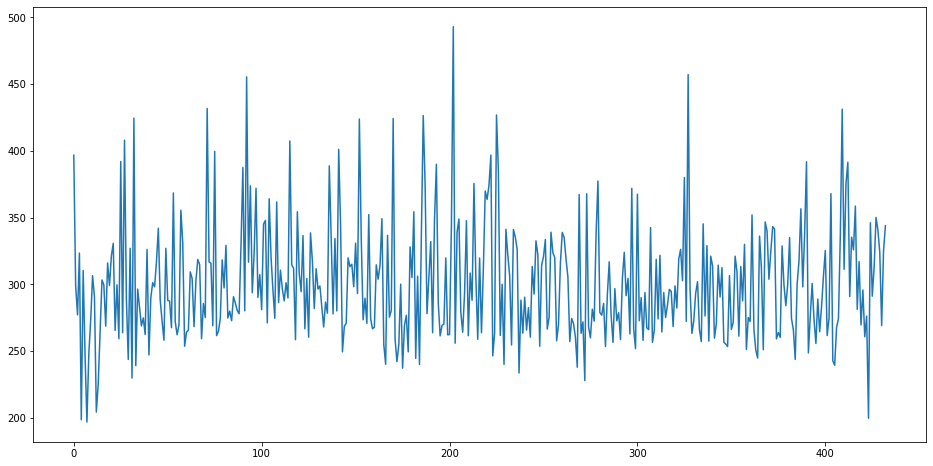

In [31]:
# load history
#full_hist = np.load("saved/history15.npy")
#full_hist = np.concatenate((full_hist, np.array(history.history["episode_reward"])))
# save history
#np.save("saved/history15.npy", full_hist)
np.save("saved/history20.npy", np.array(history.history["episode_reward"]))

plt.rcParams["figure.figsize"] = (16, 8)
#plt.plot(moving_average(full_hist, 10))
#plt.plot(full_hist)
plt.plot(np.array(history.history["episode_reward"]))
plt.show()

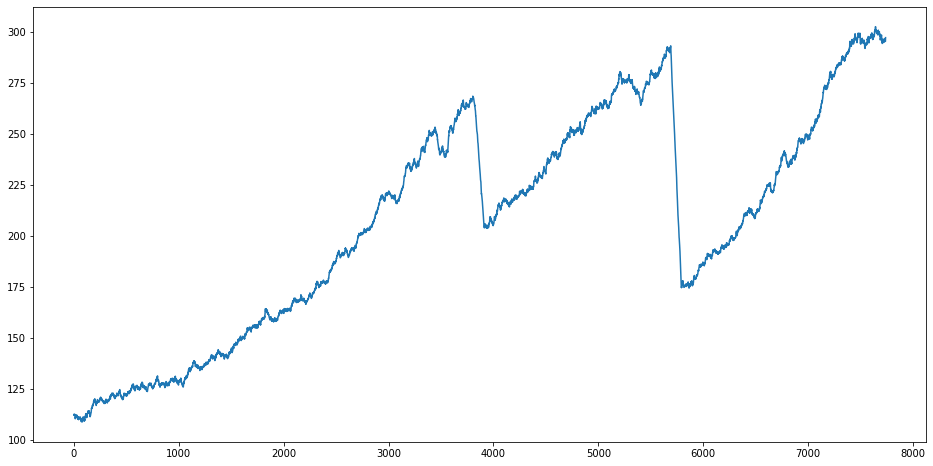

In [25]:
load17 = np.load("saved/history17.npy")
load18 = np.load("saved/history18.npy")
load19 = np.load("saved/history19.npy")
total = np.concatenate((load17, load18, load19))
plt.plot(moving_average(total, 100))
plt.show()

## The End